# Лабораторная работа №2. Решение жестких систем ОДУ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Формулировка задачи

Рассматривается следующая система обыкновенных дифференциальных уравнений (ОДУ), являющаяся моделью двухлампового генератора Фрюгауфа (Frühauf):

$\begin{cases}
\varepsilon \dot{x}_1 = -\alpha (y_1 - y_2) + \phi(x_2) - x_1, \\
\varepsilon \dot{x}_2 = \alpha (y_1 - y_2) + \phi(x_1) - x_2, \\
\dot{y}_1 = x_1, \\
\dot{y}_2 = x_2,
\end{cases}$

где:
- $\phi(u) = -\tan(\pi u / 2)$,
- $\alpha = 1$,
- $\varepsilon = 10^{-3}$ (параметр жесткости системы),
- начальные условия: $x_1(0) = 0$, $x_2(0) = 0$, $y_1(0) = 2$, $y_2(0) = 0$,
- интервал интегрирования: $t \in [0, 5]$.

Система является жесткой из-за малого значения $\varepsilon$, что приводит к быстрым изменениям в переменных $x_1$ и $x_2$. Для её решения применяются численные методы, устойчивые к жесткости: неявные методы Рунге-Кутты (Radau IIA 3-го и 5-го порядков, Gauss-Legendre 4-го порядка), методы Адамса-Мултона 3-5 порядков, а также методы Розенброка-Ваннера 1-3 порядков.

In [2]:
# Problem param
Dim = 4
alpha = 1.0  
T = 5.0      
eps = 1e-4   # Newton accuracy
epsilon = 1e-3 
y_0 = [0, 0, 2, 0]

# default step
N = 100000  
h = T / N


# Phi(u) function
def phi(u):
    u = np.clip(u, -0.85, 0.85)
    return -np.tan(np.pi * u / 2)

# Right part of ODE system
def f(t, y):
    x1, x2, y1, y2 = y
    
    dx1_dt = (-alpha * (y1 - y2) + phi(x2) - x1) / epsilon
    dx2_dt = (alpha * (y1 - y2) + phi(x1) - x2) / epsilon
    dy1_dt = x1
    dy2_dt = x2
    return np.array([dx1_dt, dx2_dt, dy1_dt, dy2_dt])

### 1. Вспомогательные методы

#### 1.1. Метод Ньютона
- Используется для решения неявных уравнений в методах Рунге-Кутты и Адамса-Мултона.
- Итерационная формула:
  
  $ x^{(k+1)} = x^{(k)} - J^{-1} F(x^{(k)}), $
  где $F(x)$ — остаточная функция, а $J$ — Якобиан $F$, вычисляемый численно методом конечных разностей.

#### 1.2. Метод Зейделя
- Применяется для решения линейных систем вида $Ax = b$, возникающих в методе Ньютона, а также в методе Розенброка-Ваннера.
- Итерационная формула:
  $ x_i^{(k+1)} = \frac{1}{a_{ii}} \left( b_i - \sum_{j=1}^{i-1} a_{ij} x_j^{(k+1)} - \sum_{j=i+1}^n a_{ij} x_j^{(k)} \right). $
- Используется для вычисления приращений в методе Ньютона.

#### 1.3. Явный метод Рунге-Кутты 4-го порядка
- Применяется для вычисления начальных значений $y_1, y_2, \ldots$ в методах Адамса-Мултона, где требуется несколько предыдущих точек.
- Формула:
  $ y_{n+1} = y_n + \frac{h}{6} (k_1 + 2k_2 + 2k_3 + k_4), $
  где:
  - $k_1 = f(t_n, y_n)$,
  - $k_2 = f(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_1)$,
  - $k_3 = f(t_n + \frac{h}{2}, y_n + \frac{h}{2} k_2)$,
  - $k_4 = f(t_n + h, y_n + h k_3)$.

In [3]:
# Zeidel method for solving system of linear equastions like Ax = b
def Zeidel (A, b, acc = 1e-6, max_iter = 1000):
    n = len(b)
    x = np.zeros(n)
    
    for iteration in range(max_iter):
        x_new = x.copy()
        
        for i in range(n):
            
            sum_1 = 0
            for j in range(i):
                sum_1 += A[i][j] * x_new[j]
                
            sum_2 = 0
            for j in range(i + 1, n):
                sum_2 += A[i][j] * x[j]
                
            x_new[i] = (b[i] - sum_1 - sum_2) / A[i][i]
            
        if np.linalg.norm(x_new - x) < acc:
            return x_new
            
        x = x_new
        
    return x

# Newton method for solving systems of nonlinear equations like F(x) = 0
def Newton_SNE (F, J, x0, acc = 1e-6, max_iter = 100):
    x = x0.copy()
    
    for iteration in range(max_iter):
        F_x = F(x)
        J_x = J(x)
        
        delta = Zeidel (J_x, -F_x, acc)
        x = x + delta
        
        if np.linalg.norm(delta) < acc:
            break
            
    return x

### 2. Неявные методы Рунге-Кутты

#### 2.1. Radau IIA 3-го порядка (2 стадии)
- **Коэффициенты**:
  - Матрица $A$:
  
   $ A = \begin{bmatrix}
    \frac{5}{12} & -\frac{1}{12} \\
    \frac{3}{4} & \frac{1}{4}
    \end{bmatrix} $
  
  - Веса $b$: $\begin{bmatrix} \frac{3}{4}, \frac{1}{4} \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} \frac{1}{3}, 1 \end{bmatrix}$.

#### 2.2. Gauss-Legendre 4-го порядка (2 стадии)
- **Коэффициенты**:
  - Матрица $A$:

   $ A = \begin{bmatrix}
    \frac{1}{4} & \frac{1}{4} - \frac{\sqrt{3}}{6} \\
    \frac{1}{4} + \frac{\sqrt{3}}{6} & \frac{1}{4}
    \end{bmatrix} $
  
  - Веса $b$: $\begin{bmatrix} \frac{1}{2}, \frac{1}{2} \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} \frac{1}{2} - \frac{\sqrt{3}}{6}, \frac{1}{2} + \frac{\sqrt{3}}{6} \end{bmatrix}$.

#### 2.3. Radau IIA 5-го порядка (3 стадии)
- **Коэффициенты**:
  - Матрица $A$:

    $ A = \begin{bmatrix}
    \frac{88}{360} - \frac{7\sqrt{6}}{72} & -\frac{296}{360} + \frac{77\sqrt{6}}{360} & -\frac{8}{360} + \frac{\sqrt{6}}{36} \\
    -\frac{296}{360} - \frac{77\sqrt{6}}{360} & \frac{88}{360} + \frac{7\sqrt{6}}{72} & -\frac{8}{360} - \frac{\sqrt{6}}{36} \\
    \frac{16}{45} - \frac{2\sqrt{6}}{45} & \frac{16}{45} + \frac{2\sqrt{6}}{45} & \frac{7}{90}
    \end{bmatrix} $
    
  - Веса $b$: $\begin{bmatrix} \frac{16}{45} - \frac{2\sqrt{6}}{45}, \frac{16}{45} + \frac{2\sqrt{6}}{45}, \frac{7}{90} \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} \frac{4 - \sqrt{6}}{10}, \frac{4 + \sqrt{6}}{10}, 1 \end{bmatrix}$.

In [4]:
# Coeff. for implicit Runge-Kutta methods for stiff ODE systems (Radau IIA & Gauss-Legendre)

# 1) Radau IIA of 3 order (2-stages)
radau3_A = np.array([[5/12, -1/12], [3/4, 1/4]])
radau3_b = np.array([3/4, 1/4])
radau3_c = np.array([1/3, 1.0])

# 2) Gauss-Legendre of 4 order (2-stages)
gauss4_A = np.array([[1/4, 1/4 - np.sqrt(3)/6], [1/4 + np.sqrt(3)/6, 1/4]])
gauss4_b = np.array([1/2, 1/2])
gauss4_c = np.array([1/2 - np.sqrt(3)/6, 1/2 + np.sqrt(3)/6])

# 3) Radau IIA of 5 order (3-stages)
radau5_A = np.array([
    [88/360 - 7*np.sqrt(6)/72, -296/360 + 77*np.sqrt(6)/360, -8/360 + np.sqrt(6)/36],
    [-296/360 - 77*np.sqrt(6)/360, 88/360 + 7*np.sqrt(6)/72, -8/360 - np.sqrt(6)/36],
    [16/45 - 2*np.sqrt(6)/45, 16/45 + 2*np.sqrt(6)/45, 7/90]
])
radau5_b = np.array([16/45 - 2*np.sqrt(6)/45, 16/45 + 2*np.sqrt(6)/45, 7/90])
radau5_c = np.array([(4 - np.sqrt(6))/10, (4 + np.sqrt(6))/10, 1.0])

# Residual func. for implicit RK-method
def RK_resid (Y, t, y_prev, h, A, c, s):
    dim = len(y_prev)
    
    residuals = np.zeros(s * dim)
    
    for i in range(s):
        Y_i = Y[i * dim : (i+1) * dim]
        sum_A_k = np.zeros(dim)
        
        for j in range(s):
            Y_j = Y[j * dim : (j+1) * dim]
            
            sum_A_k += A[i][j] * f(t + c[j] * h, Y_j)
            
        for k in range(dim):
            residuals[i * dim + k] = Y_i[k] - y_prev[k] - h * sum_A_k[k]
            
    return residuals

# Jacobian for implicit RK-method
def RK_J (Y, t, y_prev, h, A, c, s, dim):
    
    J = np.zeros((s * dim, s * dim))
    h_J = 1e-6
    
    F = RK_resid (Y, t, y_prev, h, A, c, s)
    
    for i in range(s * dim):
        Y_eps = Y.copy()
        Y_eps[i] += h_J
        
        F_eps = RK_resid (Y_eps, t, y_prev, h, A, c, s)
        
        for j in range(s * dim):
            J[j][i] = (F_eps[j] - F[j]) / h_J
            
    return J

# Implicit RK solver
def solve_RK (method_name, A, b, c):
    s = len(b)
    dim = Dim
    y = np.zeros((N + 1, dim))
    y[0] = y_0
    t = np.linspace(0, T, N + 1)

    checkpoints = 0
    start_time = time.time()
    print("-------------------------------------------------------------------")
    
    for n in range(N):
        if checkpoints == int(N / 10):
            print("Progress of RK method (", method_name, ") is : ", int(n / N * 100), "%")
            checkpoints = 0
        
        t_n = t[n]
        y_prev = y[n]
        Y0 = np.tile(y_prev, s)
        
        def F(Y):
            return RK_resid (Y, t_n, y_prev, h, A, c, s)
        
        def J(Y):
            return RK_J (Y, t_n, y_prev, h, A, c, s, dim)
        
        Y = Newton_SNE (F, J, Y0, acc = eps)
        
        y_next = y_prev.copy()
        
        for i in range(s):
            Y_i = Y[i * dim : (i+1) * dim]
            
            for j in range(dim):
                y_next[j] += h * b[i] * f(t_n + c[i] * h, Y_i)[j]
        
        if np.any(np.isnan(y_next)) or np.any(np.isinf(y_next)):
            raise ValueError(f"Overflow on step {n+1} in method {method_name}")

        checkpoints += 1
        
        y[n + 1] = y_next
        
    res_time = time.time() - start_time
    print("Execution time: ", int(res_time / 60), "min, ", int(res_time) % 60, "sec. ")
    print("-------------------------------------------------------------------")
    
    return t, y

### 3. Методы Адамса-Мултона

#### 3.1. Адамса-Мултона 3-го порядка
- **Формула**:
  $
  y_{n+1} = y_n + h \left( \frac{5}{12} f(t_{n+1}, y_{n+1}) + \frac{8}{12} f(t_n, y_n) - \frac{1}{12} f(t_{n-1}, y_{n-1}) \right).
  $

#### 2.2. Адамса-Мултона 4-го порядка
- **Формула**:
  $
  y_{n+1} = y_n + h \left( \frac{9}{24} f(t_{n+1}, y_{n+1}) + \frac{19}{24} f(t_n, y_n) - \frac{5}{24} f(t_{n-1}, y_{n-1}) + \frac{1}{24} f(t_{n-2}, y_{n-2}) \right).
  $

#### 2.3. Адамса-Мултона 5-го порядка
- **Формула**:
  $
  y_{n+1} = y_n + h \left( \frac{251}{720} f(t_{n+1}, y_{n+1}) + \frac{646}{720} f(t_n, y_n) - \frac{264}{720} f(t_{n-1}, y_{n-1}) + \frac{106}{720} f(t_{n-2}, y_{n-2}) - \frac{19}{720} f(t_{n-3}, y_{n-3}) \right).
  $

In [5]:
# Residual func. for Adams-Moulton method
def AM_resid(y, t, h, prev_terms, order):
    
    if order == 3:
        coeffs = [5/12, 8/12, -1/12]
        prev_vals = prev_terms[-2:]
        history_term = 0
        
        for i in range(len(coeffs) - 1):
            history_term += coeffs[i + 1] * f(t - (i + 1) * h, prev_vals[-(i + 1)])
            
        return y - prev_vals[-1] - h * (coeffs[0] * f(t, y) + history_term)
        
    elif order == 4:
        coeffs = [9/24, 19/24, -5/24, 1/24]
        prev_vals = prev_terms[-3:]
        history_term = 0
        
        for i in range(len(coeffs) - 1):
            history_term += coeffs[i + 1] * f(t - (i + 1) * h, prev_vals[-(i + 1)])
            
        return y - prev_vals[-1] - h * (coeffs[0] * f(t, y) + history_term)
        
    elif order == 5:
        coeffs = [251/720, 646/720, -264/720, 106/720, -19/720]
        prev_vals = prev_terms[-4:]
        history_term = 0
        
        for i in range(len(coeffs) - 1):
            history_term += coeffs[i + 1] * f(t - (i + 1) * h, prev_vals[-(i + 1)])
            
        return y - prev_vals[-1] - h * (coeffs[0] * f(t, y) + history_term)

# Jacobian for AM-method
def AM_J (y, t, h, prev_terms, order):
    h_J = 1e-6
    J = np.zeros((Dim, Dim))
    F = AM_resid (y, t, h, prev_terms, order)
    
    for i in range(Dim):
        y_eps = y.copy()
        y_eps[i] += h_J
        
        F_eps = AM_resid (y_eps, t, h, prev_terms, order)
        
        for j in range(Dim):
            J[j][i] = (F_eps[j] - F[j]) / h_J
            
    return J

# Explicit RK-4 method for initial AM-values
def explicit_RK4(t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    
    return y + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)

# AM solver
def solve_AM (order):
    y = np.zeros((N + 1, Dim))
    y[0] = y_0
    t = np.linspace(0, T, N + 1)
    
    checkpoints = 0
    start_time = time.time()
    print("-------------------------------------------------------------------")

    # Get initial values using explicit RK-4 method
    for i in range(order - 1):
        y[i + 1] = explicit_RK4 (t[i], y[i], h)
        
        if np.any(np.isnan(y[i + 1])) or np.any(np.isinf(y[i + 1])):
            raise ValueError(f"Overflow on step {i+1} in AM initial values calculations")
    
    # Main part
    for n in range(order - 1, N):
        if checkpoints == int(N / 10):
            print("Progress of AM method (", order, ") is : ", int(n / N * 100), "%")
            checkpoints = 0
        
        t_n = t[n + 1]
        prev_terms = list(y[n - (order - 1) + 1 : n + 1])
        
        def F(y_next):
            return AM_resid (y_next, t_n, h, prev_terms, order)
        
        def J(y_next):
            return AM_J (y_next, t_n, h, prev_terms, order)
        
        y[n + 1] = Newton_SNE (F, J, y[n], acc = eps)
        
        if np.any(np.isnan(y[n + 1])) or np.any(np.isinf(y[n + 1])):
            raise ValueError(f"Overflow in step {n+1} in AM method")

        checkpoints += 1
    
    res_time = time.time() - start_time
    print("Execution time: ", int(res_time / 60), "min, ", int(res_time) % 60, "sec. ")
    print("-------------------------------------------------------------------")
    
    return t, y


### 4. Методы Розенброка-Ваннера

#### 4.1. Метод Розенброка 1-го порядка (1 стадия)
- **Коэффициенты**:
  - Матрица $\alpha$:
    $
    \alpha = \begin{bmatrix} 0 \end{bmatrix}
    $
  - Матрица $\gamma$:
    $
    \gamma = \begin{bmatrix} 1 \end{bmatrix}
    $
  - Веса $m$: $\begin{bmatrix} 1 \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} 0 \end{bmatrix}$.
- **Формула**:
  - Приращение $k_1$ находится из:
    $
    (E - h \gamma_{11} J) k_1 = f(t_n, y_n),
    $
  - Следующий шаг:
    $
    y_{n+1} = y_n + m_1 k_1.
    $

#### 4.2. Метод Розенброка 2-го порядка (2 стадии)
- **Коэффициенты**:
  - $\gamma = 1.7071, b = 0.2929$
  - Матрица $\alpha$:
    $
    \alpha = \begin{bmatrix}
    0 & 0 \\
    \frac{1}{2(1 - b)} & 0
    \end{bmatrix}
    $
  - Матрица $\gamma$:
    $
    \gamma = \begin{bmatrix}
    \gamma & 0 \\
    \frac{-\gamma}{(1 - b)} & \gamma
    \end{bmatrix}
    $
  - Веса $m$: $\begin{bmatrix} b, 1 - b \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} 0, b \end{bmatrix}$.
- **Формула**:
  - Приращения $k_1$ и $k_2$:
    $
    (E - h \gamma_{11} J) k_1 = f(t_n, y_n),
    $
    $
    (E - h \gamma_{22} J) k_2 = f(t_n + h, y_n + a_{21} k_1) + g_{21} h J k_1,
    $
  - Следующий шаг:
    $
    y_{n+1} = y_n + m_1 k_1 + m_2 k_2.
    $

#### 4.3. Метод Розенброка 3-го порядка (3 стадии)
- **Коэффициенты**:
  - Матрица $\alpha$:
    $
    \alpha = \begin{bmatrix}
    0 & 0 & 0 \\
    1 & 0 & 0 \\
    0 & 1 & 0
    \end{bmatrix}
    $
  - Матрица $\gamma$:
    $
    \gamma = \begin{bmatrix}
    \frac{1}{2} + \frac{\sqrt{3}}{6} & 0 & 0 \\
    -\frac{\sqrt{3}}{3} & \frac{1}{2} + \frac{\sqrt{3}}{6} & 0 \\
    \frac{1}{2} - \frac{\sqrt{3}}{6} & -\frac{1}{2} - \frac{\sqrt{3}}{6} & \frac{1}{2} + \frac{\sqrt{3}}{6}
    \end{bmatrix}
    $
  - Веса $m$: $\begin{bmatrix} \frac{1}{2} - \frac{\sqrt{3}}{6}, -\frac{1}{2} - \frac{\sqrt{3}}{6}, 1 \end{bmatrix}$,
  - Узлы $c$: $\begin{bmatrix} 0, \frac{1}{2} + \frac{\sqrt{3}}{6}, \frac{1}{2} - \frac{\sqrt{3}}{6} \end{bmatrix}$.

In [6]:
def matrix_to_vector (A, b):
    res = np.zeros(Dim)

    for i in range(Dim):
        for j in range(Dim):
            res[i] += A[i][j] * b[j]

    return res

# Jacobian for RW methods
def RW_J (y, eps=1e-6):
    J = np.zeros((Dim, Dim))
    
    f_0 = f(0, y)

    for j in range(Dim):
        dy = y.copy()
        dy[j] += eps
        
        df = f(0, dy)
        
        J[:, j] = (df - f_0) / eps
    
    return J

# Rosenbrock-Wanner method of order 1
def solve_RW1 (f, y_0, h, N):
    y = np.zeros((N + 1, Dim))
    y[0] = y_0
    t = np.linspace(0, T, N + 1)

    checkpoints = 0
    start_time = time.time()
    print("-------------------------------------------------------------------")
    
    for n in range(N):
        if checkpoints == int(N / 10):
            print("Progress of RW method ( 1 ) is : ", int(n / N * 100), "%")
            checkpoints = 0
            
        J = RW_J(y[n])
        A = np.identity(Dim) - h  * J
        
        k1 = Zeidel (A, h * f(0, y[n]))
        y[n + 1] = y[n] + k1

        if np.any(np.isnan(y[n + 1])) or np.any(np.isinf(y[n + 1])):
            raise ValueError(f"Overflow in step {n+1} in RW-1 method")

        checkpoints += 1

    res_time = time.time() - start_time
    print("Execution time: ", int(res_time / 60), "min, ", int(res_time) % 60, "sec. ")
    print("-------------------------------------------------------------------")
    
    return t, y

# Rosenbrock-Wanner method of order 2
def solve_RW2 (f, y_0, h, N):
    y = np.zeros((N + 1, Dim))
    y[0] = y_0
    t = np.linspace(0, T, N + 1)
    
    g = 1.7071
    b = 0.2929
    a21 = 0.5 / (1 - b)
    g21 = - g / (1 - b)

    checkpoints = 0
    start_time = time.time()
    print("-------------------------------------------------------------------")

    for n in range(N):
        if checkpoints == int(N / 10):
            print("Progress of RW method ( 2 ) is : ", int(n / N * 100), "%")
            checkpoints = 0
        
        J = RW_J (y[n])
        A = np.identity(Dim) - h * g  * J
        
        k1 = Zeidel (A, h * f(0, y[n]))
        k2 = Zeidel (A, h * f(0, y[n] + a21 * k1) + g21 * h * matrix_to_vector (J, k1))
        y[n + 1] = y[n] + b * k1 + (1 - b) * k2

        if np.any(np.isnan(y[n + 1])) or np.any(np.isinf(y[n + 1])):
            raise ValueError(f"Overflow in step {n+1} in RW-2 method")

        checkpoints += 1

    res_time = time.time() - start_time
    print("Execution time: ", int(res_time / 60), "min, ", int(res_time) % 60, "sec. ")
    print("-------------------------------------------------------------------")
        
    return t, y

# Rosenbrock-Wanner method of order 3
def solve_RW3 (f, y_0, h, N):
    y = np.zeros((N + 1, Dim))
    y[0] = y_0
    t = np.linspace(0, T, N + 1)
    
    p1 = 0.435866521508459
    p2 = 0.4782408332745185
    p3 = 0.0858926452170225
    b32 = -2.116053335949811
    
    checkpoints = 0
    start_time = time.time()
    print("-------------------------------------------------------------------")
    
    for n in range(N):
        if checkpoints == int(N / 10):
            print("Progress of RW method ( 3 ) is : ", int(n / N * 100), "%")
            checkpoints = 0
            
        J = RW_J (y[n])
        A = np.identity(Dim) + h * p1  * J
        
        k1 = Zeidel (A, h * f(0, y[n]))
        k2 = Zeidel (A, h * f(0, y[n] + p1 * k1))
        k3 = Zeidel (A, h * f(0, y[n] + p1 * k1 + b32 * k2))
        y[n + 1] = y[n] + p1 * k1 + p2 * k2 + p3 * k3

        if np.any(np.isnan(y[n + 1])) or np.any(np.isinf(y[n + 1])):
            raise ValueError(f"Overflow in step {n+1} in RW-3 method")

        checkpoints += 1

    res_time = time.time() - start_time
    print("Execution time: ", int(res_time / 60), "min, ", int(res_time) % 60, "sec. ")
    print("-------------------------------------------------------------------")
    
    return t, y

In [7]:
methods_RK = {
    'Radau3': (radau3_A, radau3_b, radau3_c),
    'Gauss4': (gauss4_A, gauss4_b, gauss4_c),
    'Radau5': (radau5_A, radau5_b, radau5_c)
}
solutions_RK = {}

N = 200000  
h = T / N

# Solve using all RK methods
for method_name in methods_RK:
    params = methods_RK[method_name]
    
    try:
            
        A, b, c = params
        t, y = solve_RK (method_name, A, b, c)
            
        solutions_RK[method_name] = (t, y)
        
    except ValueError as e:
        print(f"Error for method {method_name}: {e}")


-------------------------------------------------------------------
Progress of RK method ( Radau3 ) is :  10 %
Progress of RK method ( Radau3 ) is :  20 %
Progress of RK method ( Radau3 ) is :  30 %
Progress of RK method ( Radau3 ) is :  40 %
Progress of RK method ( Radau3 ) is :  50 %
Progress of RK method ( Radau3 ) is :  60 %
Progress of RK method ( Radau3 ) is :  70 %
Progress of RK method ( Radau3 ) is :  80 %
Progress of RK method ( Radau3 ) is :  90 %
Execution time:  8 min,  1 sec. 
-------------------------------------------------------------------
-------------------------------------------------------------------
Progress of RK method ( Gauss4 ) is :  10 %
Progress of RK method ( Gauss4 ) is :  20 %
Progress of RK method ( Gauss4 ) is :  30 %
Progress of RK method ( Gauss4 ) is :  40 %
Progress of RK method ( Gauss4 ) is :  50 %
Progress of RK method ( Gauss4 ) is :  60 %
Progress of RK method ( Gauss4 ) is :  70 %
Progress of RK method ( Gauss4 ) is :  80 %
Progress of RK 

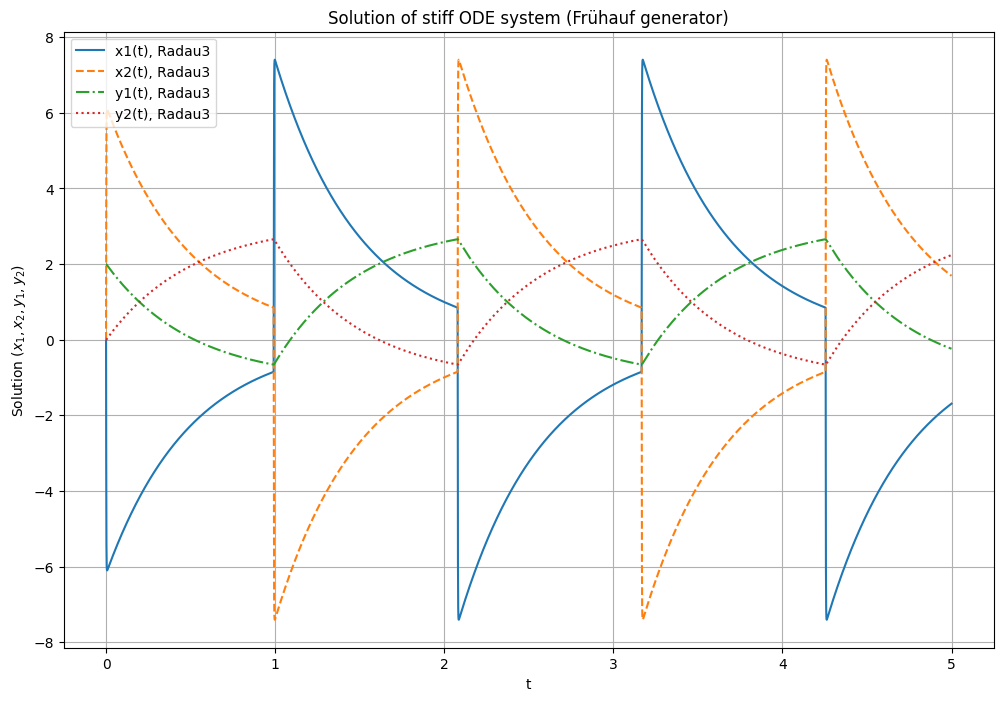

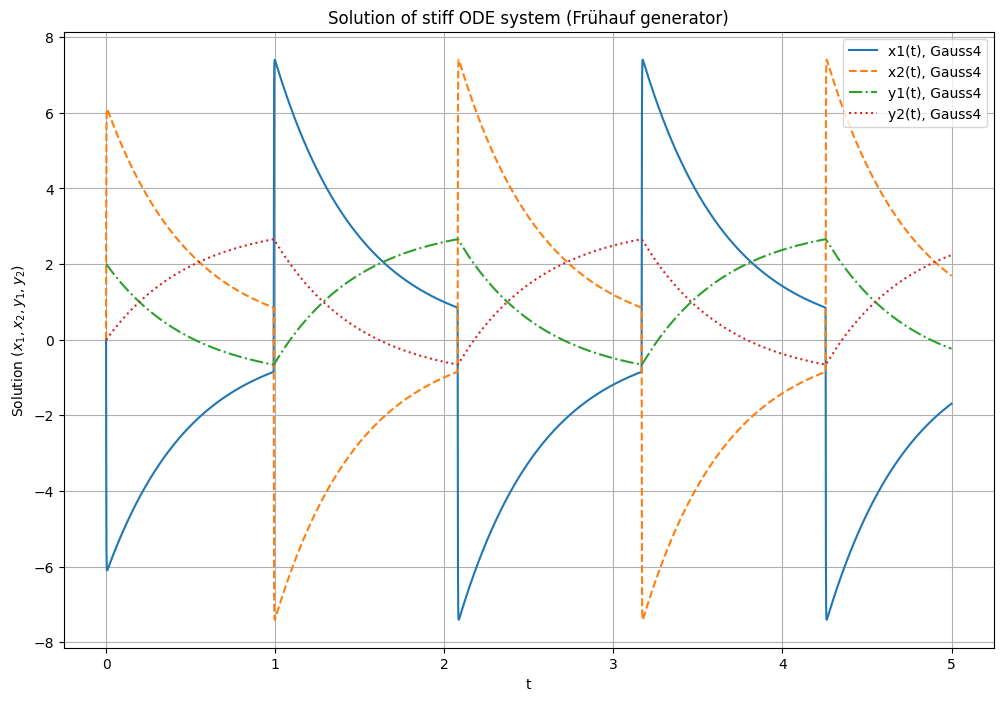

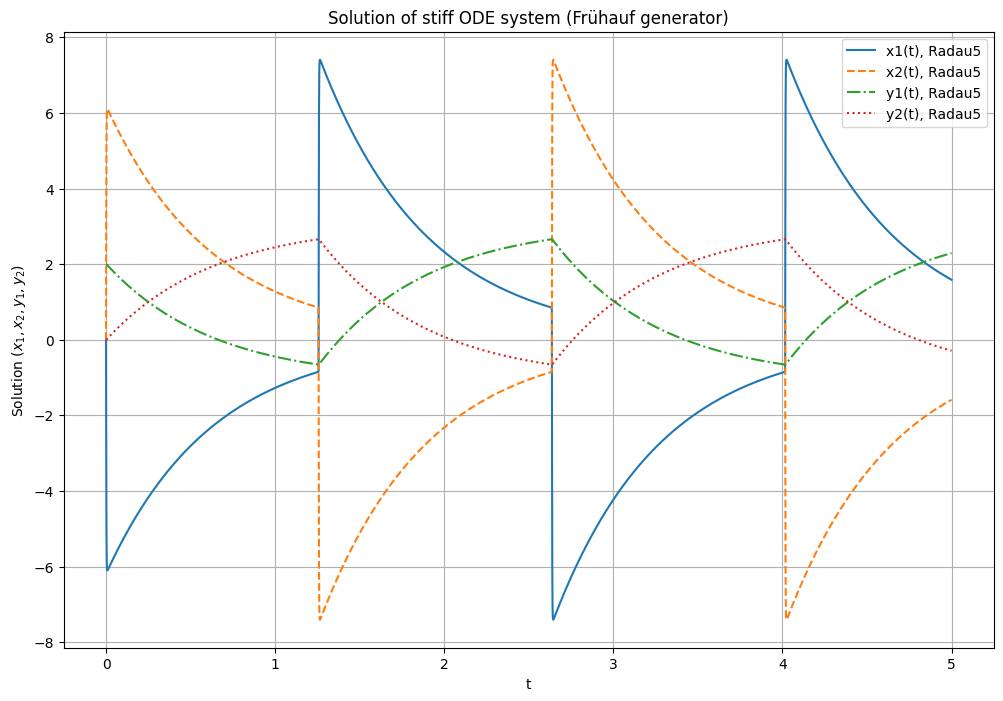

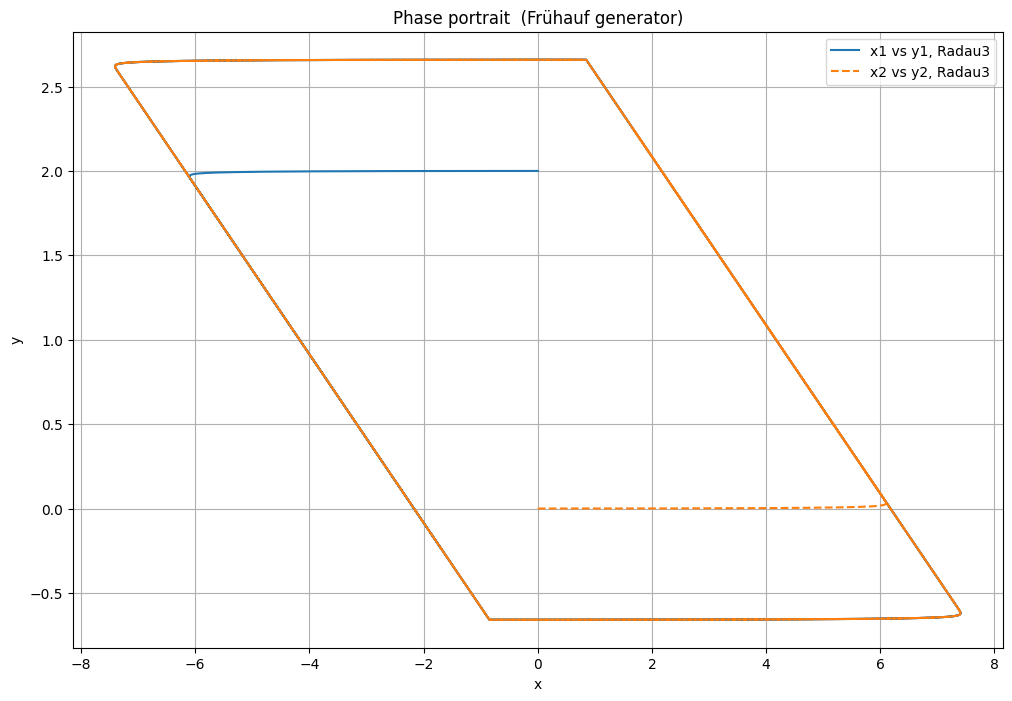

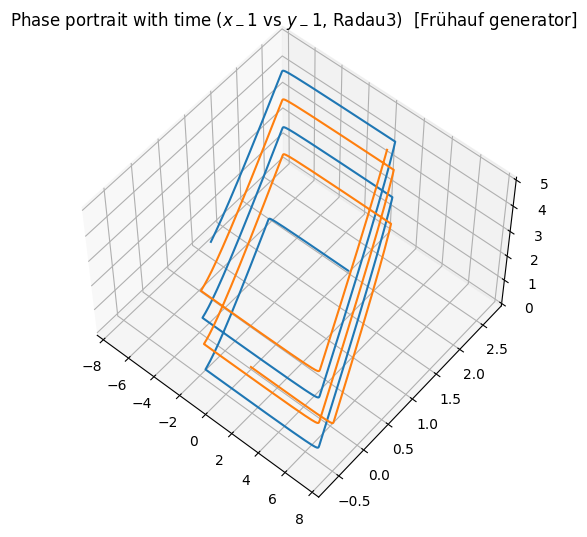

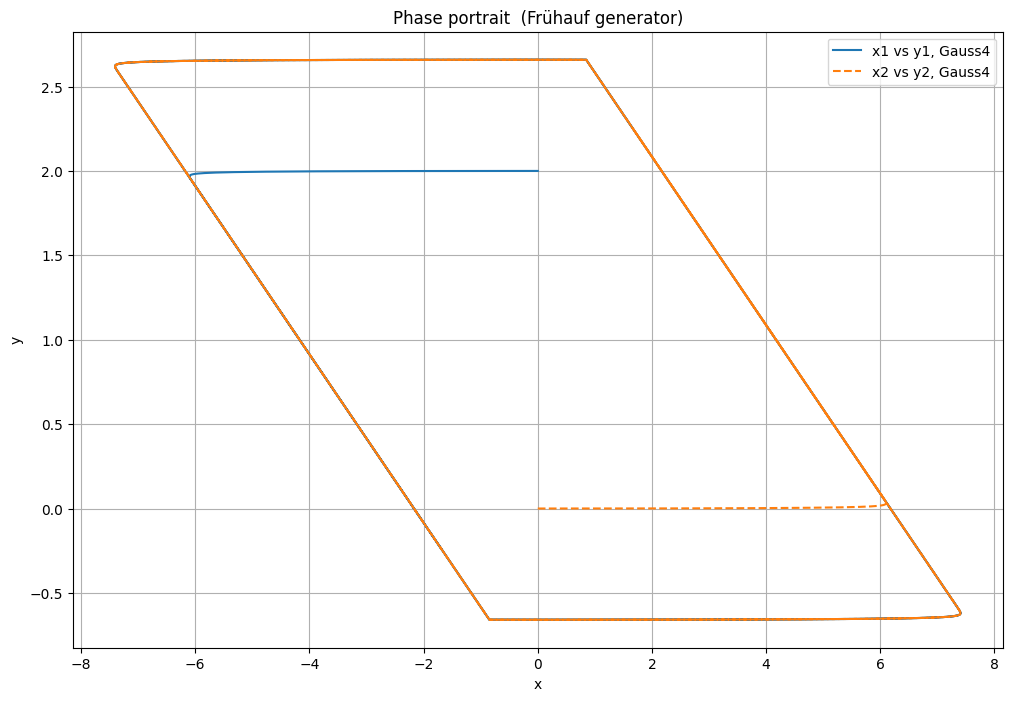

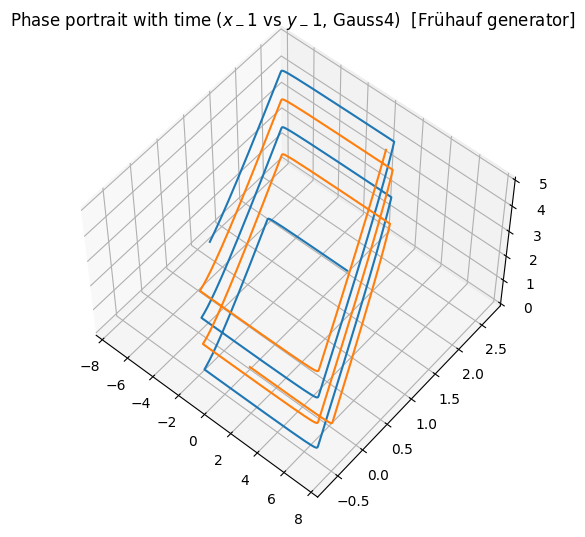

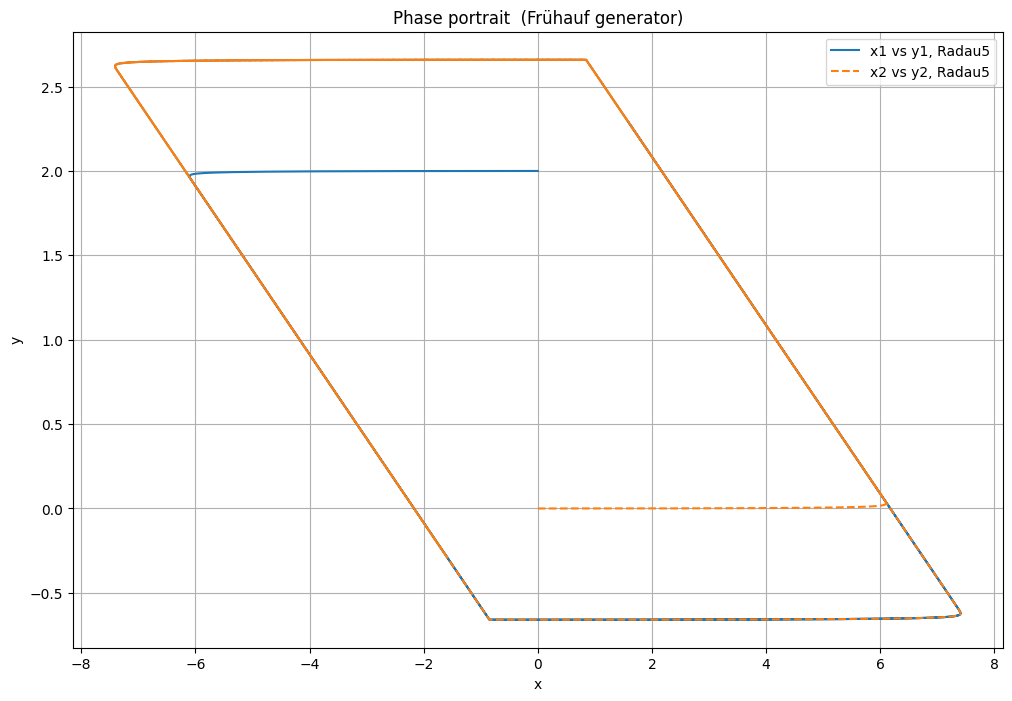

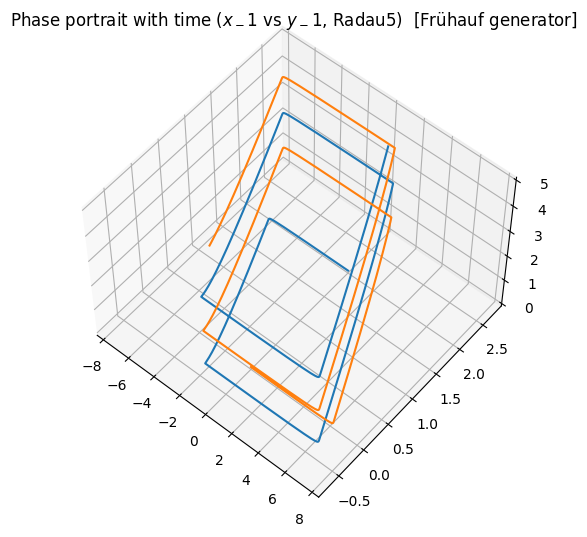

In [21]:
# Drawing plots of solutions
for method_name in solutions_RK:
    fig = plt.figure(figsize=(12, 8))
    plot = fig.add_subplot()
    
    t, y = solutions_RK[method_name]
    
    if Dim == 4:
        plt.plot(t, y[:, 0], label=f'x1(t), {method_name}')
        plt.plot(t, y[:, 1], linestyle='--', label=f'x2(t), {method_name}')
        plt.plot(t, y[:, 2], linestyle='-.', label=f'y1(t), {method_name}')
        plt.plot(t, y[:, 3], linestyle=':', label=f'y2(t), {method_name}')

        plt.xlabel('t')
        plt.ylabel('Solution ($x_1, x_2, y_1, y_2)$')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

    else:
        plt.plot(t, y[:, 0], color='green', label=f'x(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.title(f'Solution of stiff ODE system  (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

        fig = plt.figure(figsize=(12, 8))
        plot = fig.add_subplot()
        plt.plot(t, y[:, 1], color='red', label=f'z(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.title(f'Solution of stiff ODE system  (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

# Drawing phase portraits
for method_name in solutions_RK:
    plt.figure(figsize=(12, 8))
    _, y = solutions_RK[method_name]

    if Dim == 4:
        plt.plot(y[:, 0], y[:, 2], label=f'x1 vs y1, {method_name}')
        plt.plot(y[:, 1], y[:, 3], linestyle='--', label=f'x2 vs y2, {method_name}')
        plt.ylabel('y')

    else:
        plt.plot(y[:, 0], y[:, 1], label=f'x vs z, {method_name}')
        plt.ylabel('z')
        
    plt.xlabel('x')
    plt.title(f'Phase portrait  (Frühauf generator)')
    plt.legend()
    plt.grid()
    plt.show()

    if Dim == 4:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(projection='3d')
        ax.plot(y[:, 0], y[:, 2], t, label='parametric curve')
        ax.plot(y[:, 1], y[:, 3], t, label='parametric curve')
        ax.view_init(elev=55, azim=-50)
        plt.title(f'Phase portrait with time ($x_{1-2}$ vs $y_{1-2}$, {method_name})  [Frühauf generator]')
        plt.show()

In [9]:
methods_AM = {
    'AM3': 3,
    'AM4': 4,
    'AM5': 5
}
solutions_AM = {}

N = 70000  
h = T / N

# Solve using all AM methods
for method_name in methods_AM:
    params = methods_AM[method_name]
    
    try:
        t, y = solve_AM (params)
            
        solutions_AM[method_name] = (t, y)
        
    except ValueError as e:
        print(f"Error for method {method_name}: {e}")

-------------------------------------------------------------------
Progress of AM method ( 3 ) is :  10 %
Progress of AM method ( 3 ) is :  20 %
Progress of AM method ( 3 ) is :  30 %
Progress of AM method ( 3 ) is :  40 %
Progress of AM method ( 3 ) is :  50 %
Progress of AM method ( 3 ) is :  60 %
Progress of AM method ( 3 ) is :  70 %
Progress of AM method ( 3 ) is :  80 %
Progress of AM method ( 3 ) is :  90 %
Execution time:  1 min,  4 sec. 
-------------------------------------------------------------------
-------------------------------------------------------------------
Progress of AM method ( 4 ) is :  10 %
Progress of AM method ( 4 ) is :  20 %
Progress of AM method ( 4 ) is :  30 %
Progress of AM method ( 4 ) is :  40 %
Progress of AM method ( 4 ) is :  50 %
Progress of AM method ( 4 ) is :  60 %
Progress of AM method ( 4 ) is :  70 %
Progress of AM method ( 4 ) is :  80 %
Progress of AM method ( 4 ) is :  90 %
Execution time:  1 min,  13 sec. 
---------------------------

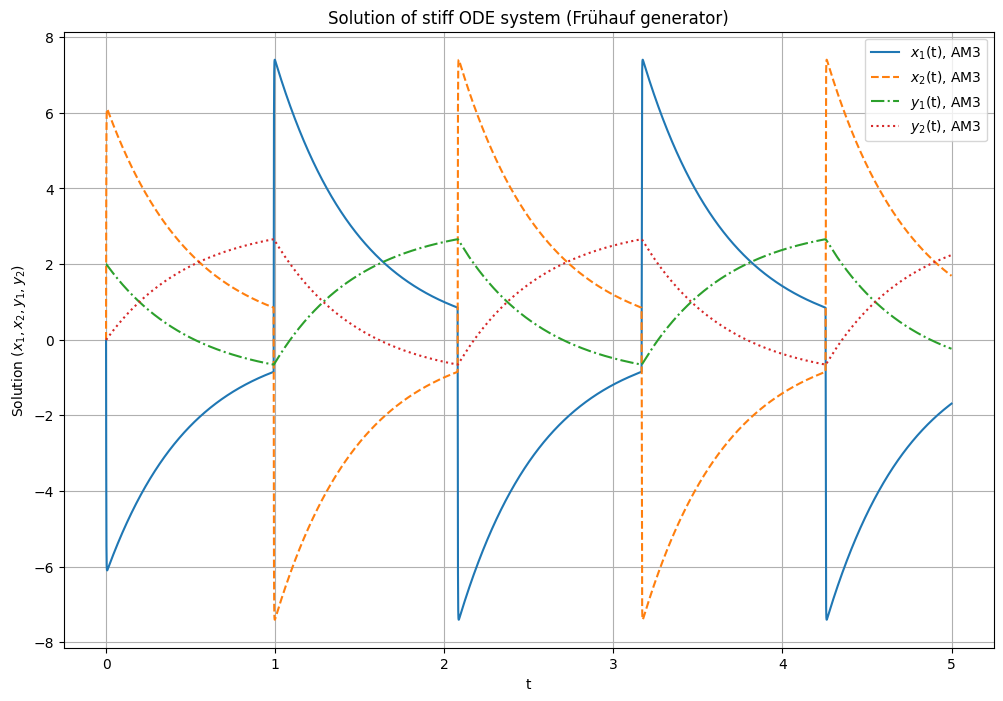

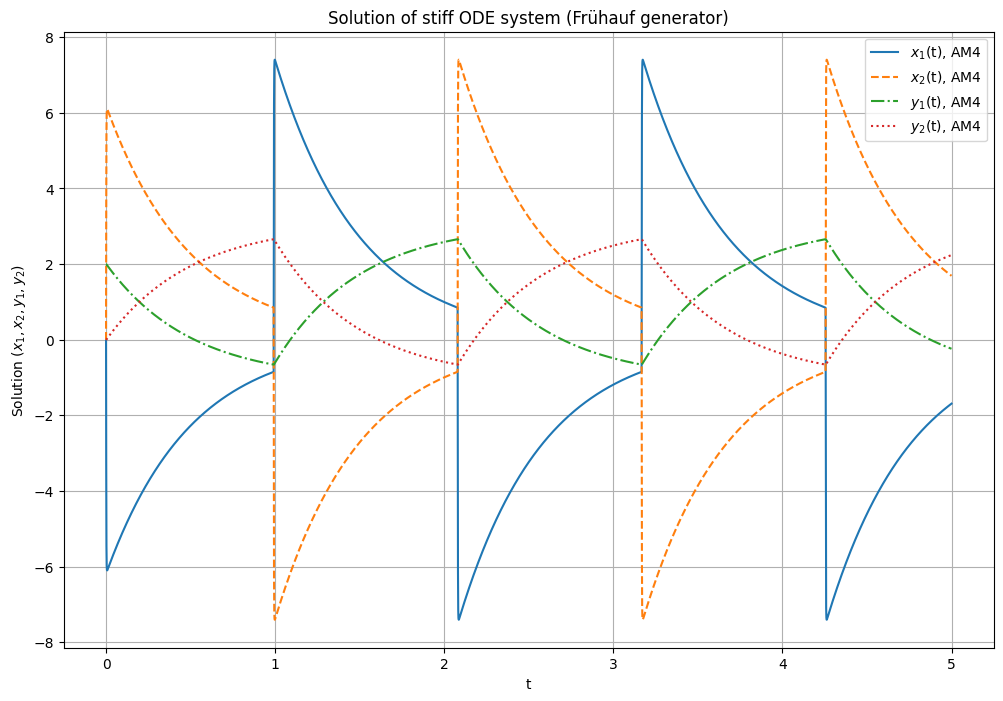

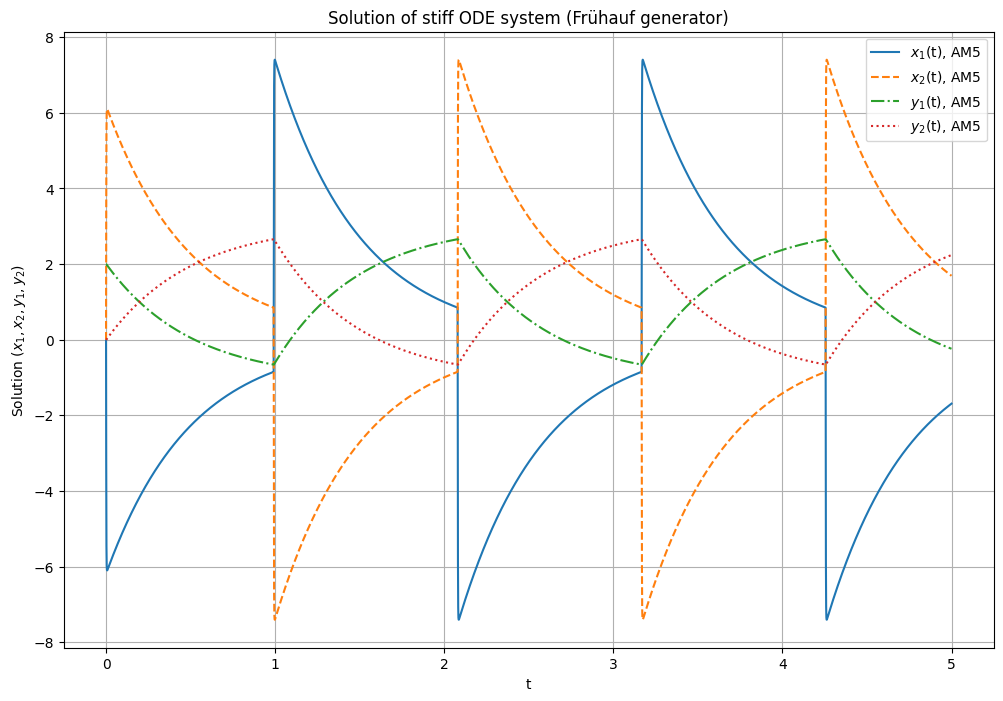

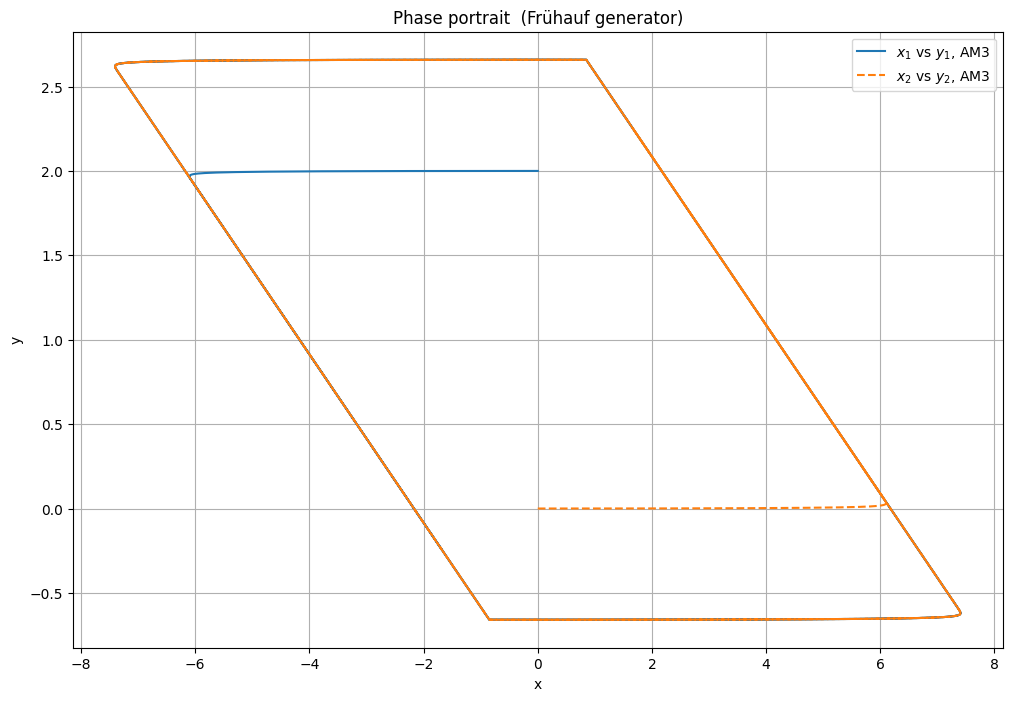

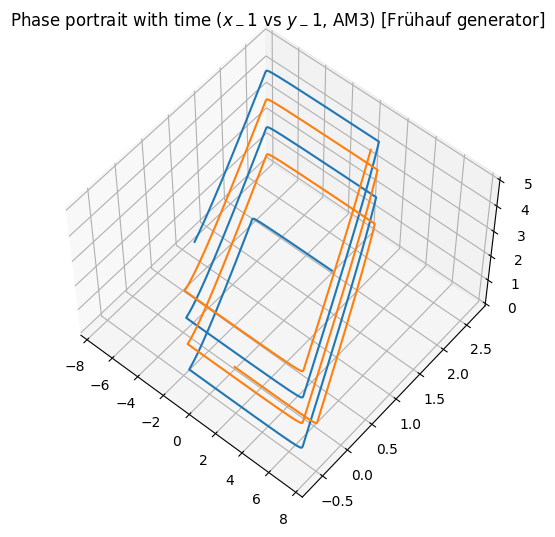

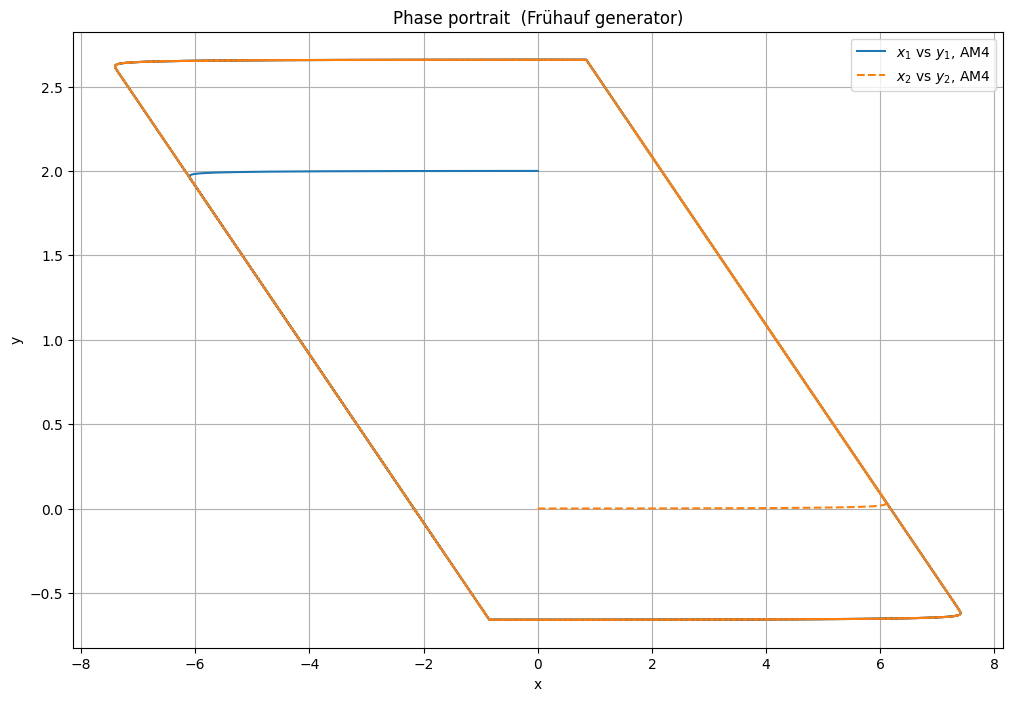

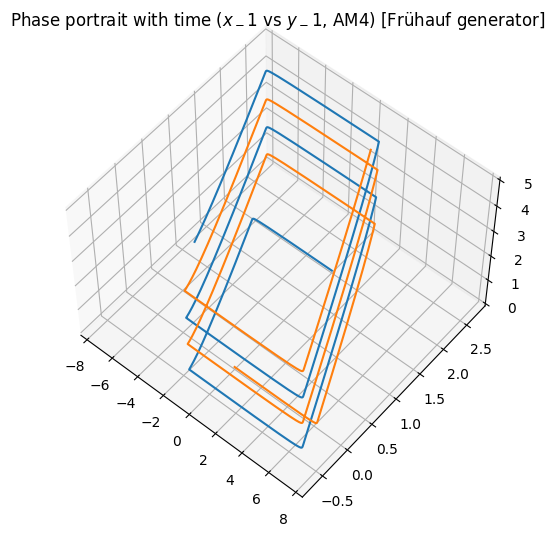

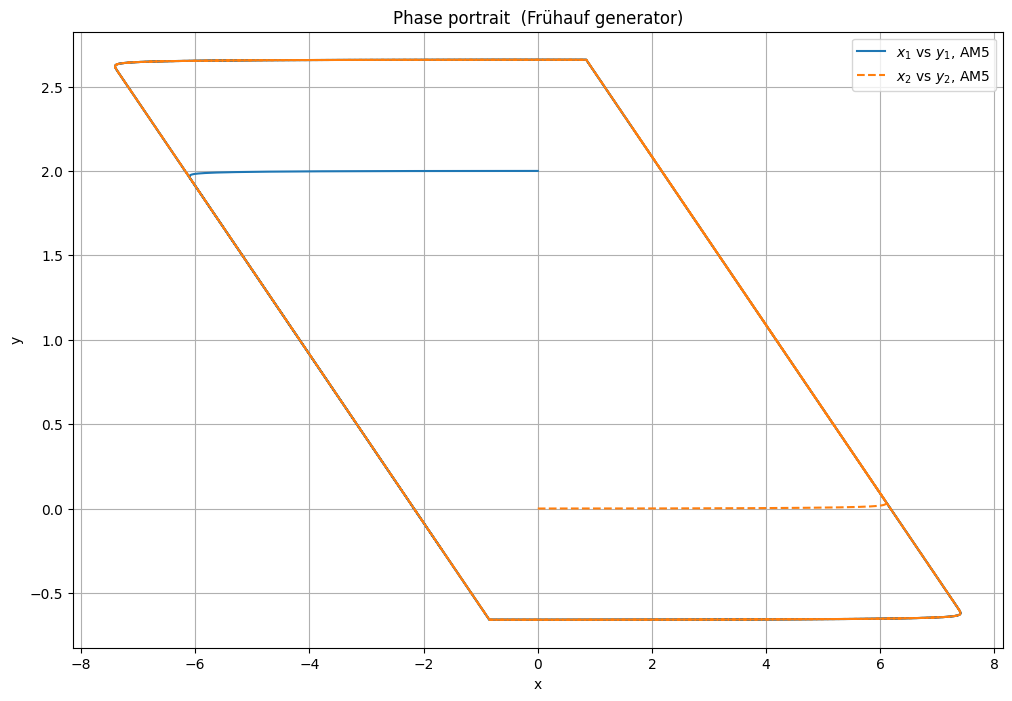

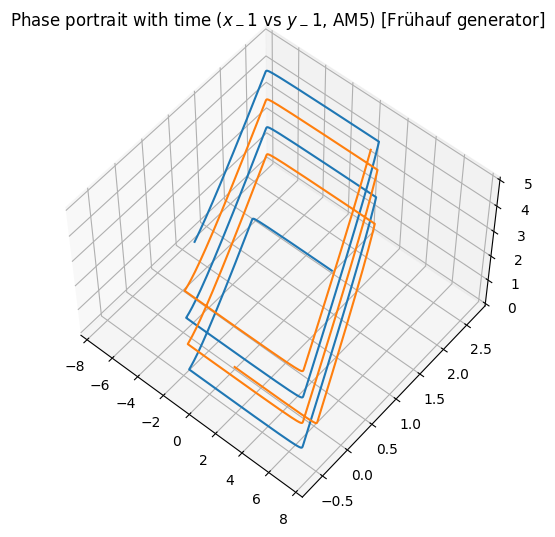

In [19]:
# Drawing plots of solutions
for method_name in solutions_AM:
    fig = plt.figure(figsize=(12, 8))
    plot = fig.add_subplot()
    
    t, y = solutions_AM[method_name]
    
    if Dim == 4:
        plt.plot(t, y[:, 0], label=f'$x_1$(t), {method_name}')
        plt.plot(t, y[:, 1], linestyle='--', label=f'$x_2$(t), {method_name}')
        plt.plot(t, y[:, 2], linestyle='-.', label=f'$y_1$(t), {method_name}')
        plt.plot(t, y[:, 3], linestyle=':', label=f'$y_2$(t), {method_name}')

        plt.xlabel('t')
        plt.ylabel('Solution ($x_1, x_2, y_1, y_2$)')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

    else:
        plt.plot(t, y[:, 0], color='green', label=f'x(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

        fig = plt.figure(figsize=(12, 8))
        plot = fig.add_subplot()
        plt.plot(t, y[:, 1], color='red', label=f'z(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

# Drawing phase portraits
for method_name in solutions_AM:
    plt.figure(figsize=(12, 8))
    _, y = solutions_AM[method_name]

    if Dim == 4:
        plt.plot(y[:, 0], y[:, 2], label=f'$x_1$ vs $y_1$, {method_name}')
        plt.plot(y[:, 1], y[:, 3], linestyle='--', label=f'$x_2$ vs $y_2$, {method_name}')
        plt.ylabel('y')

    else:
        plt.plot(y[:, 0], y[:, 1], label=f'x vs z, {method_name}')
        plt.ylabel('z')
        
    plt.xlabel('x')
    plt.title(f'Phase portrait  (Frühauf generator)')
    plt.legend()
    plt.grid()
    plt.show()

    if Dim == 4:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(projection='3d')
        ax.plot(y[:, 0], y[:, 2], t, label='parametric curve')
        ax.plot(y[:, 1], y[:, 3], t, label='parametric curve')
        ax.view_init(elev=55, azim=-50)
        plt.title(f'Phase portrait with time ($x_{1-2}$ vs $y_{1-2}$, {method_name}) [Frühauf generator]')
        plt.show()

In [13]:
methods_RW = {
    'Rosenbrock-Wanner1': (solve_RW1),
    'Rosenbrock-Wanner2': (solve_RW2),
    'Rosenbrock-Wanner3': (solve_RW3)
}
solutions_RW = {}

N = 700000  
h = T / N

# Solve using all RK methods
for method_name in methods_RW:
    params = methods_RW[method_name]
    
    try:
            
        solver = params
        t, y = solver (f, y_0, h, N)
            
        solutions_RW[method_name] = (t, y)
        
    except ValueError as e:
        print(f"Error for method {method_name}: {e}")

-------------------------------------------------------------------
Progress of RW method ( 1 ) is :  10 %
Progress of RW method ( 1 ) is :  20 %
Progress of RW method ( 1 ) is :  30 %
Progress of RW method ( 1 ) is :  40 %
Progress of RW method ( 1 ) is :  50 %
Progress of RW method ( 1 ) is :  60 %
Progress of RW method ( 1 ) is :  70 %
Progress of RW method ( 1 ) is :  80 %
Progress of RW method ( 1 ) is :  90 %
Execution time:  1 min,  53 sec. 
-------------------------------------------------------------------
-------------------------------------------------------------------
Progress of RW method ( 2 ) is :  10 %
Progress of RW method ( 2 ) is :  20 %
Progress of RW method ( 2 ) is :  30 %
Progress of RW method ( 2 ) is :  40 %
Progress of RW method ( 2 ) is :  50 %
Progress of RW method ( 2 ) is :  60 %
Progress of RW method ( 2 ) is :  70 %
Progress of RW method ( 2 ) is :  80 %
Progress of RW method ( 2 ) is :  90 %
Execution time:  2 min,  33 sec. 
--------------------------

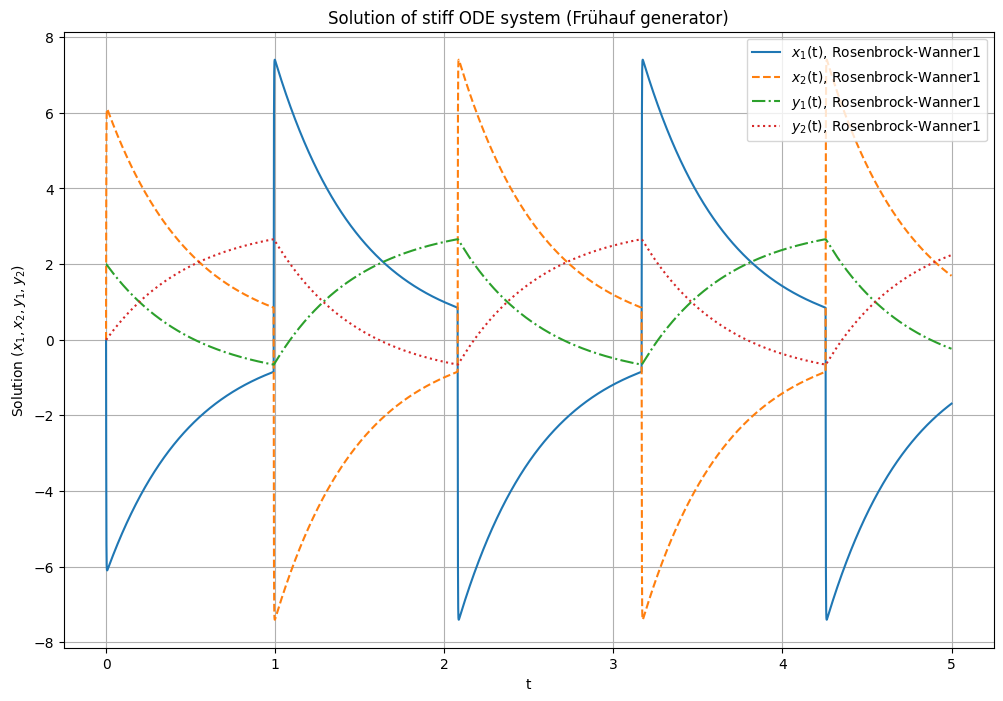

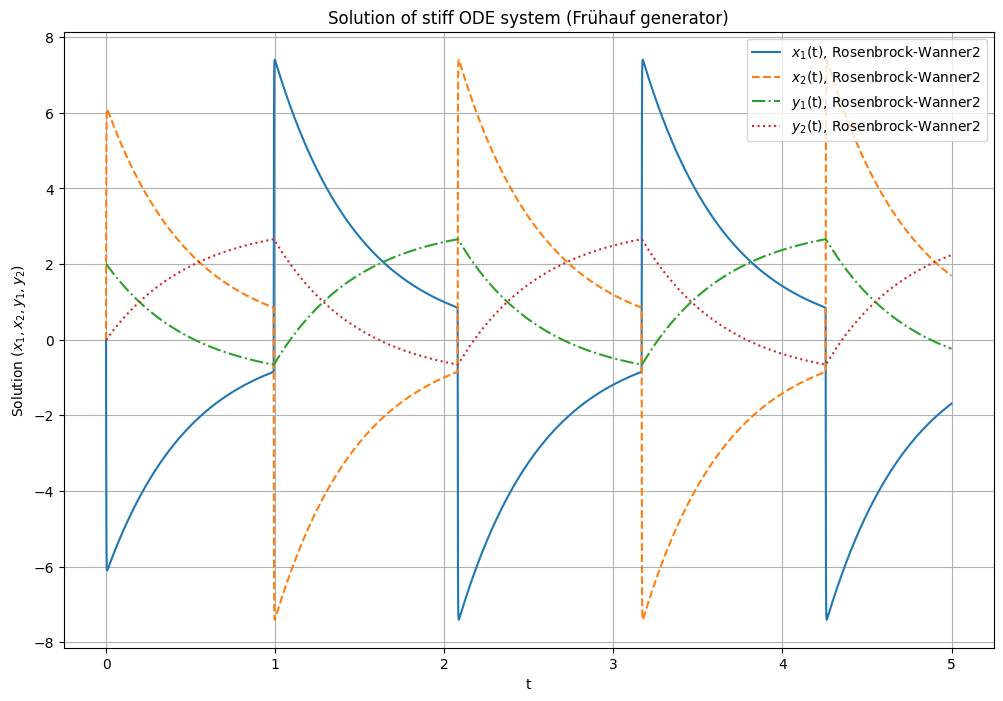

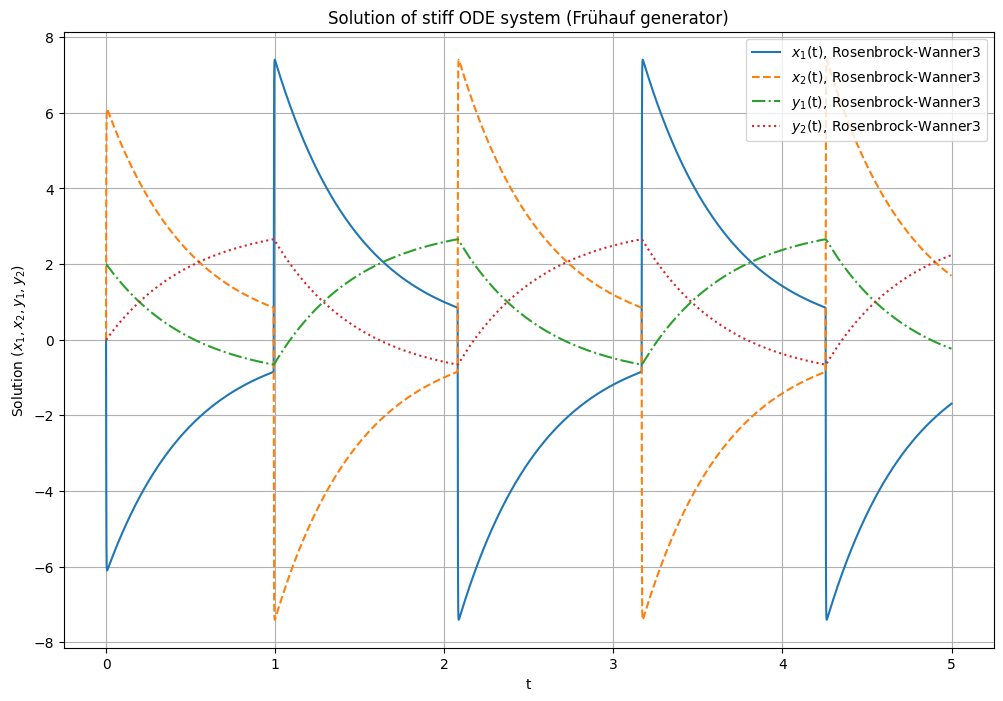

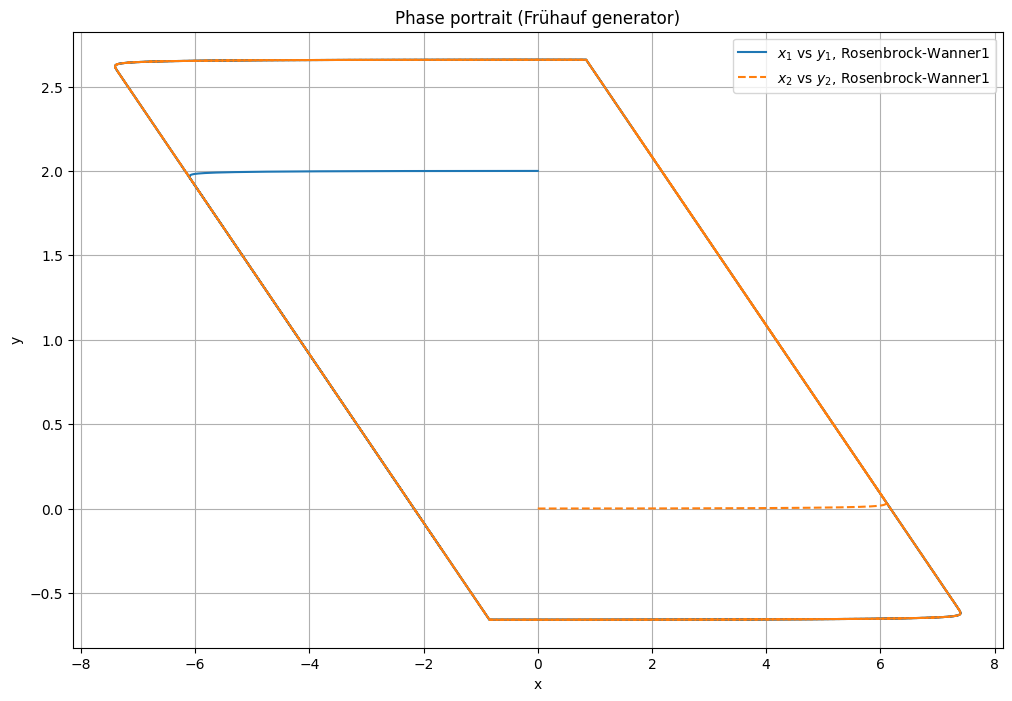

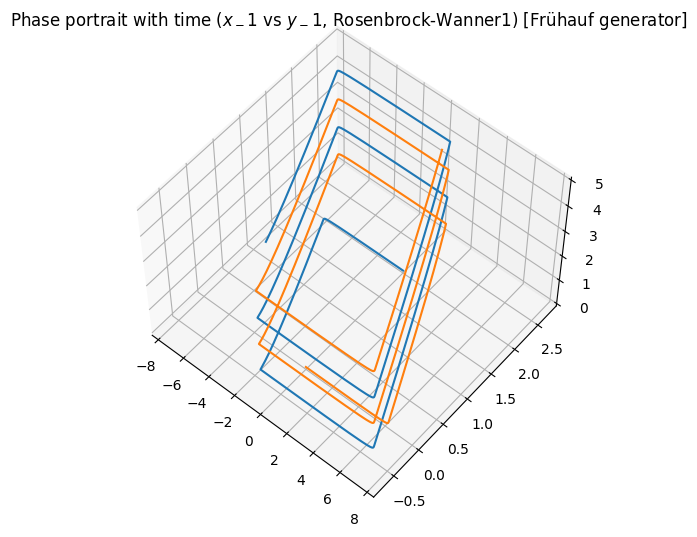

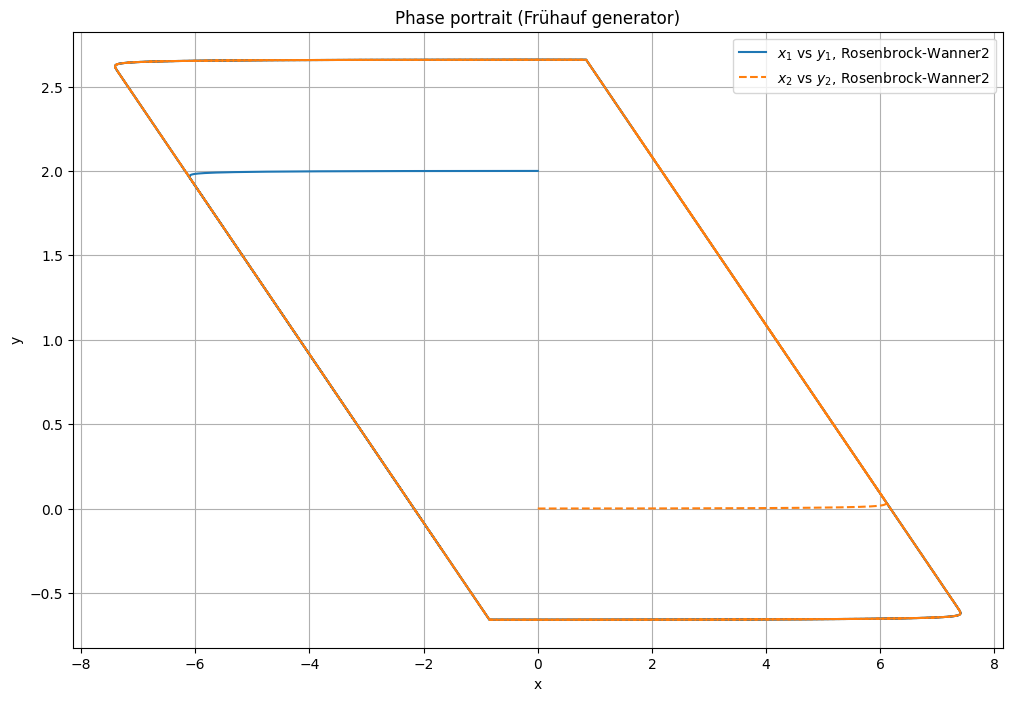

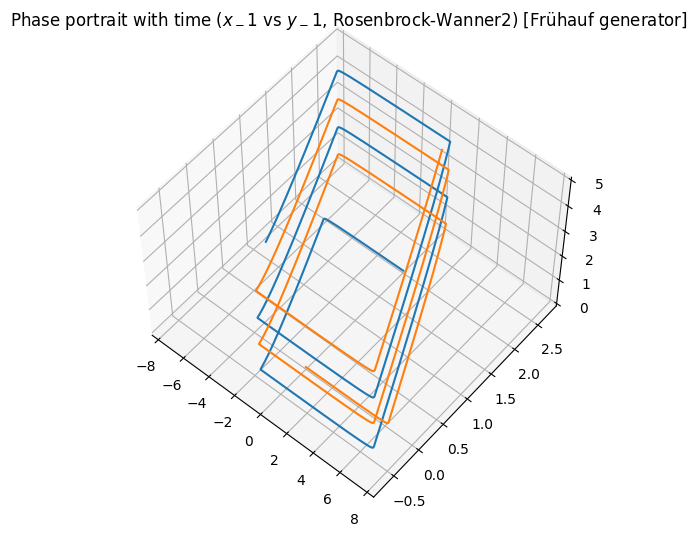

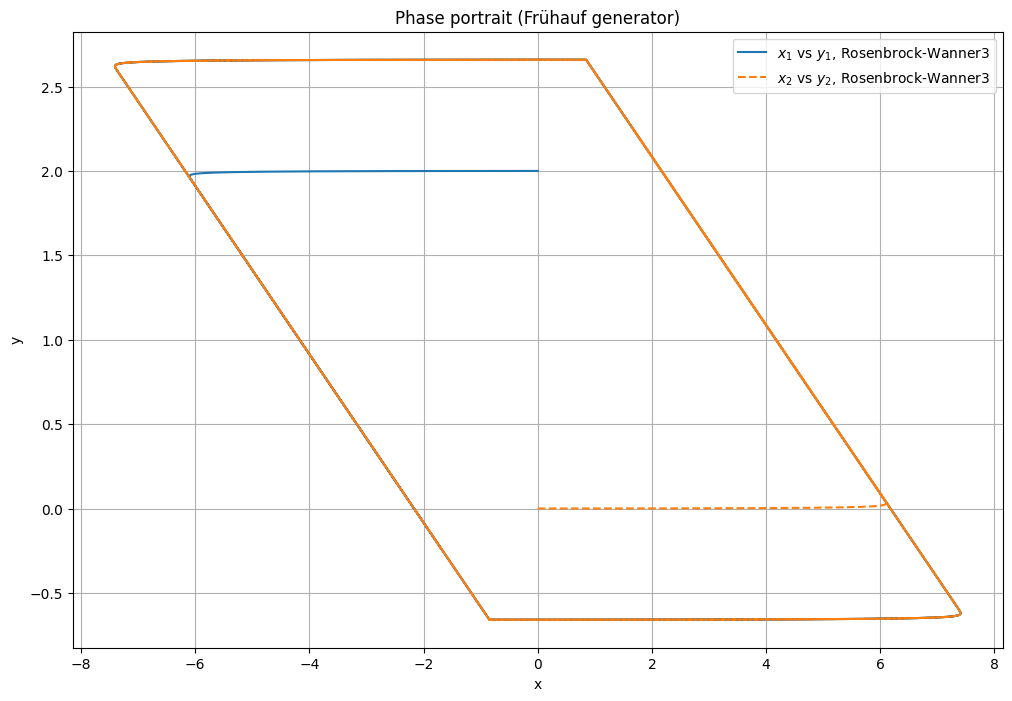

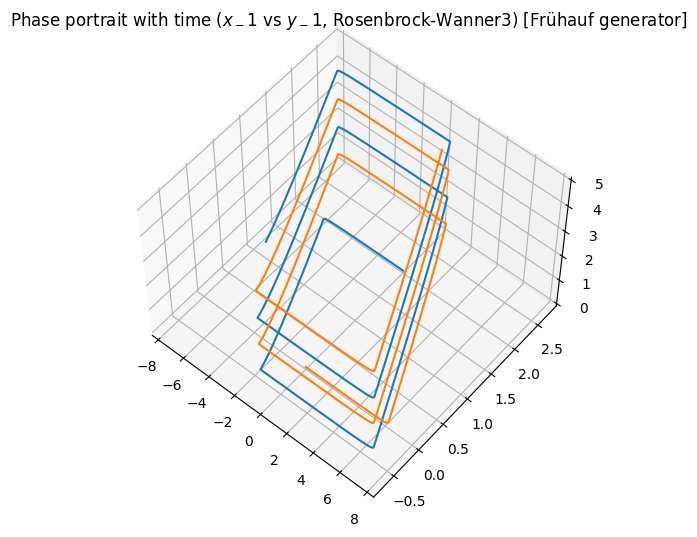

In [18]:
# Drawing plots of solutions
for method_name in solutions_RW:
    fig = plt.figure(figsize=(12, 8))
    plot = fig.add_subplot()
    
    t, y = solutions_RW[method_name]
    
    if Dim == 4:
        plt.plot(t, y[:, 0], label=f'$x_1$(t), {method_name}')
        plt.plot(t, y[:, 1], linestyle='--', label=f'$x_2$(t), {method_name}')
        plt.plot(t, y[:, 2], linestyle='-.', label=f'$y_1$(t), {method_name}')
        plt.plot(t, y[:, 3], linestyle=':', label=f'$y_2$(t), {method_name}')

        plt.xlabel('t')
        plt.ylabel('Solution ($x_1, x_2, y_1, y_2$)')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

    else:
        plt.plot(t, y[:, 0], color='green', label=f'x(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

        fig = plt.figure(figsize=(12, 8))
        plot = fig.add_subplot()
        plt.plot(t, y[:, 1], color='red', label=f'z(t), {method_name}')
        plt.xlabel('t')
        plt.ylabel('z')
        plt.title(f'Solution of stiff ODE system (Frühauf generator)')
        plt.legend()
        plt.grid()
        plt.show()

# Drawing phase portraits
for method_name in solutions_RW:
    plt.figure(figsize=(12, 8))
    _, y = solutions_RW[method_name]

    if Dim == 4:
        plt.plot(y[:, 0], y[:, 2], label=f'$x_1$ vs $y_1$, {method_name}')
        plt.plot(y[:, 1], y[:, 3], linestyle='--', label=f'$x_2$ vs $y_2$, {method_name}')
        plt.ylabel('y')

    else:
        plt.plot(y[:, 0], y[:, 1], label=f'x vs z, {method_name}')
        plt.ylabel('z')
        
    plt.xlabel('x')
    plt.title(f'Phase portrait (Frühauf generator)')
    plt.legend()
    plt.grid()
    plt.show()

    if Dim == 4:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(projection='3d')
        ax.plot(y[:, 0], y[:, 2], t, label='parametric curve')
        ax.plot(y[:, 1], y[:, 3], t, label='parametric curve')
        ax.view_init(elev=55, azim=-50)
        plt.title(f'Phase portrait with time ($x_{1-2}$ vs $y_{1-2}$, {method_name}) [Frühauf generator]')
        plt.show()

## Выводы
В данной лабораторной работе мы решили жесткую систему ОДУ на примере модели двухлампового генератора Фрюгауфа. Были применены неявные методы Рунге-Кутты (3-5 порядок), Адамса-Мултона (3-5 порядок) и Розенброка-Ваннера (1-3 порядок). Лучше всех показали себя методы из семейства Адамса-Мултона: при наибольшем среди всех шаге ($T = 5$, $N = 70000$, $h = T/N$) они сходятся за наименьшее время ($\approx 1 \:\: min$). На второе место можно поставить методы Розенброка-Ваннера: им требуется примерно такое же время, как и методам Адамса-Мултона ($\approx 2.5 \:\: min$), но необходимо сильно уменьшать шаг ($T = 5$, $N = 700000$, $h = T/N$). Однако это были методы лишь 1-3 порядка, так что более высокие методы могут оказаться более продуктивными. Хуже всего отработали неявные методы Рунге-Кутты: при необходимых $200000$ итерациях они сходились не меньше $8 \:\: min$.